In [30]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
from nn_resampler import nn_resampler
from phase_est_smc import phase_est_smc

In [32]:
num_particles = 1000 # number of SMC particles (num of w points)
num_samples = 10000 # number of samples to draw from the particle distribution (to be binned)
num_bins = 100 # number of bins
n_iters = 100 # number of different omega*
t0 = 10 # starting time
max_iters = 200# maximum number of iterations before breaking
if_print = True

In [33]:
net = nn_resampler(num_bins,num_bins)
net.load_state_dict(torch.load("model/nn_resampler.model"))
net.eval();

## NN Resampler

In [34]:
true_omegas = []
nn_preds = []
nn_data = []

for i in range(n_iters): 
    
    true_omega = np.random.uniform(low=-1, high =1) * np.pi
    
    true_omegas.append(true_omega)
    smc = phase_est_smc(true_omega, t0, max_iters)
    smc.init_particles(num_particles)
    resample_counts = 0
    
    while True:
        
        particle_pos, particle_wgts = smc.particles(threshold=num_particles/5, num_measurements=1)
        bins, edges = smc.get_bins(num_bins, num_samples)
        
        if smc.break_flag:
            break
            
        nn_pred = net(torch.tensor(bins).float().unsqueeze(0)) ## convert to float tensor, then make dim [1, num_bins]
        smc.nn_bins_to_particles(nn_pred.detach().numpy(), edges)
        
        resample_counts += 1

        
#         if len(running_est) > 5:
#             last_n = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shake of last_n with every element being last_n[0]
#             # if all elements of last_n are equal then they should all equal the first element
#             if np.allclose(last_n, np.full_like(last_n, last_n[0])):
#                 break         
    
    nn_data.append(smc.data)
    nn_preds.append(smc.curr_omega_est)
    
    if np.abs(true_omega - smc.curr_omega_est) > 1:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}. Failed".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))
        break
    else:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))

True omega: -0.946782, prediction by NN: -0.598693, num of resample calls: 45
True omega: -1.150777, prediction by NN: 2.241861, num of resample calls: 45. Failed


i= 0


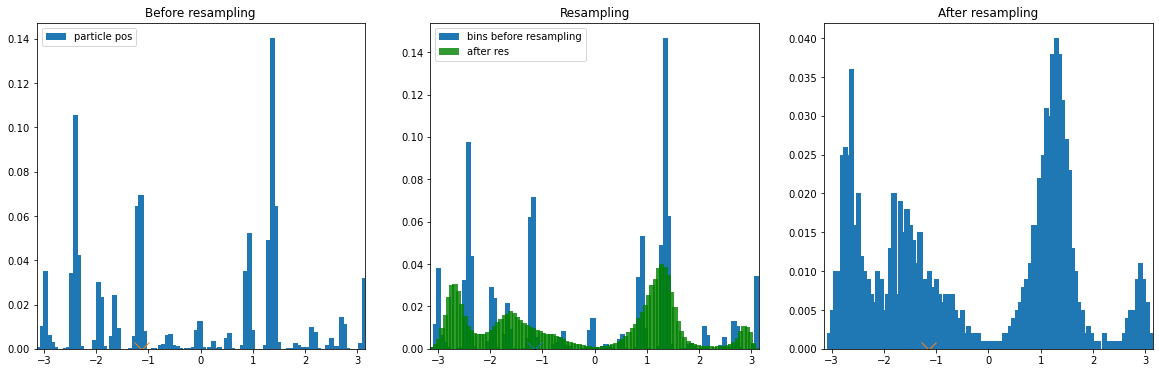

i= 1


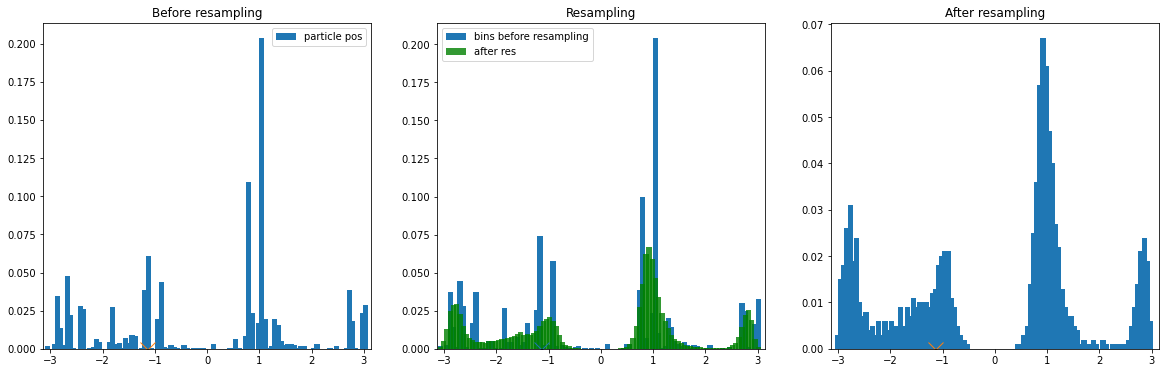

i= 2


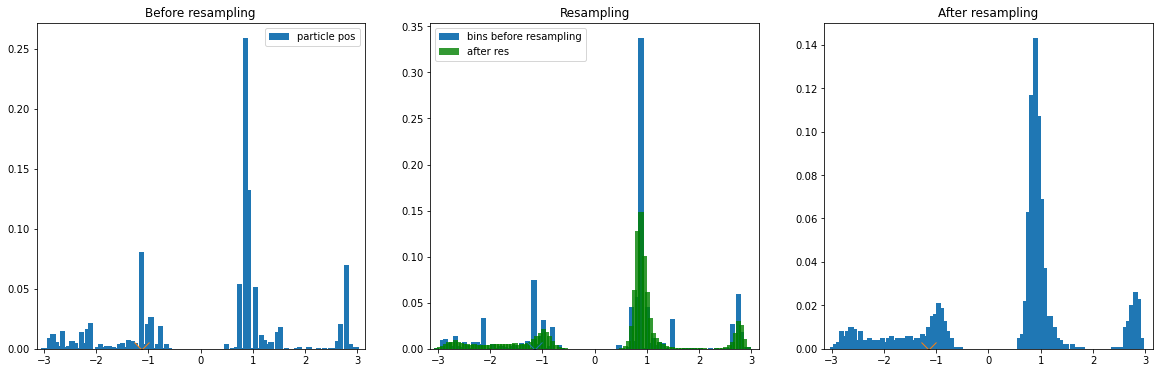

i= 3


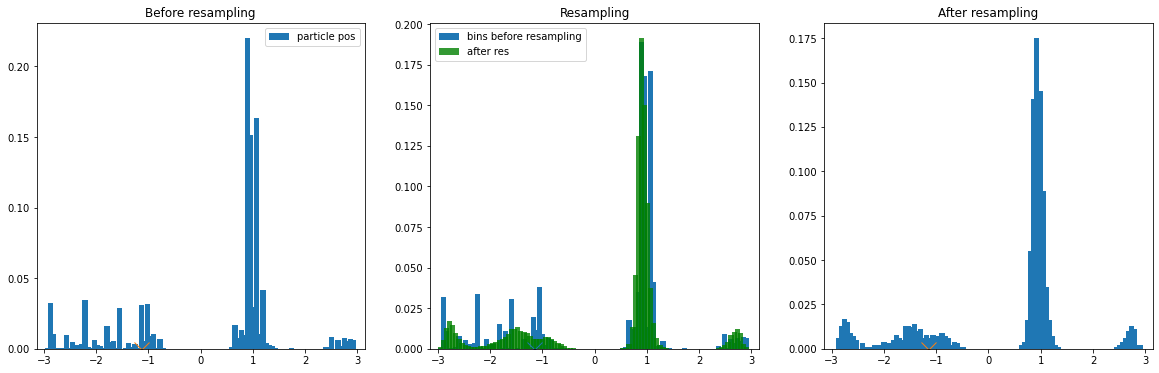

i= 4


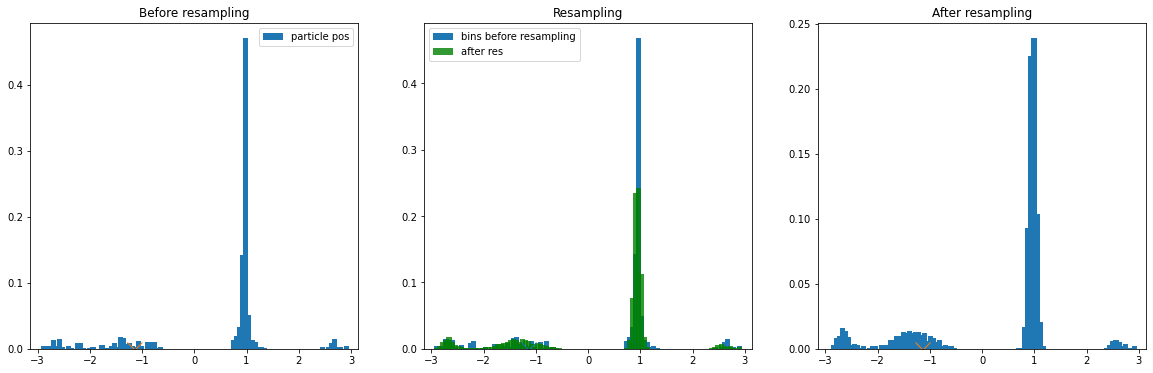

i= 5


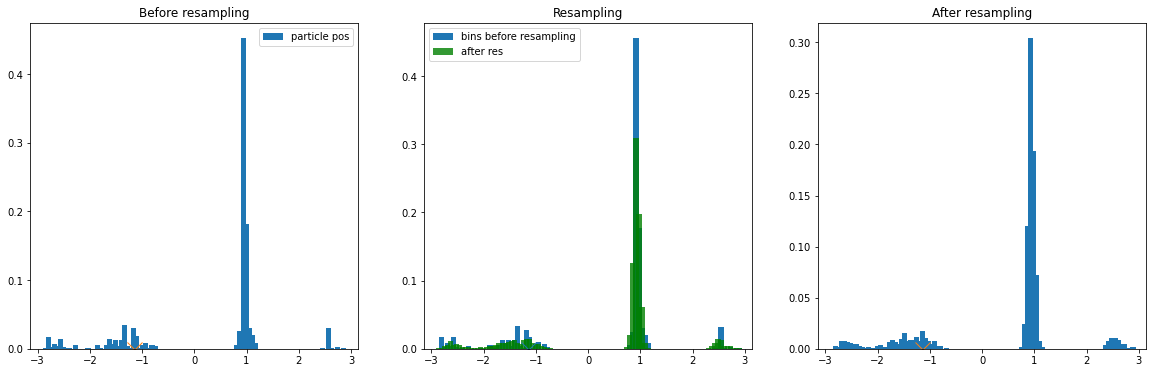

i= 6


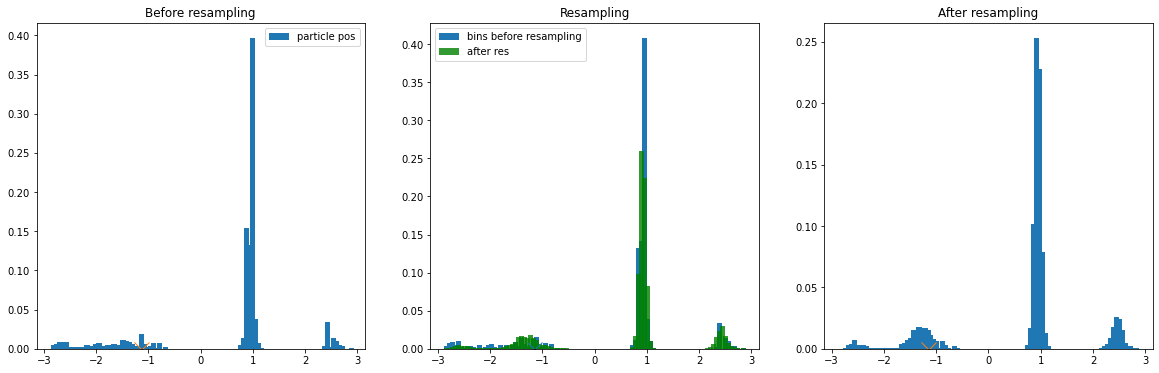

i= 7


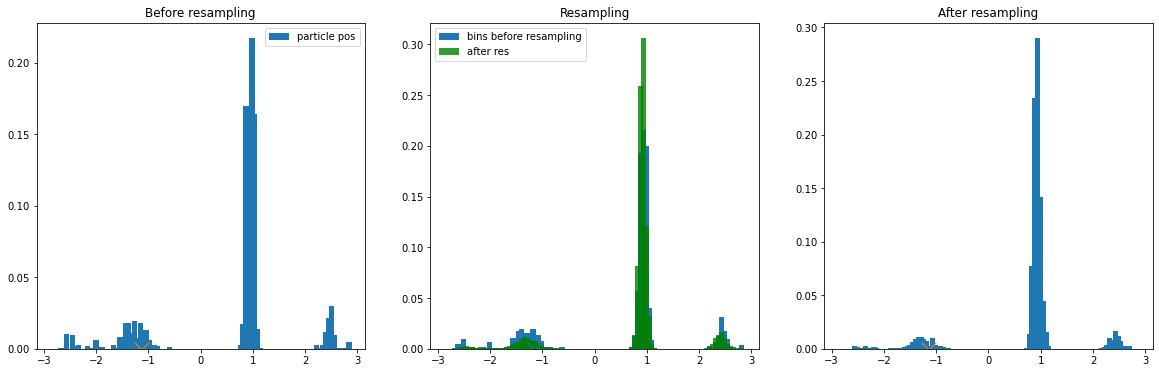

i= 8


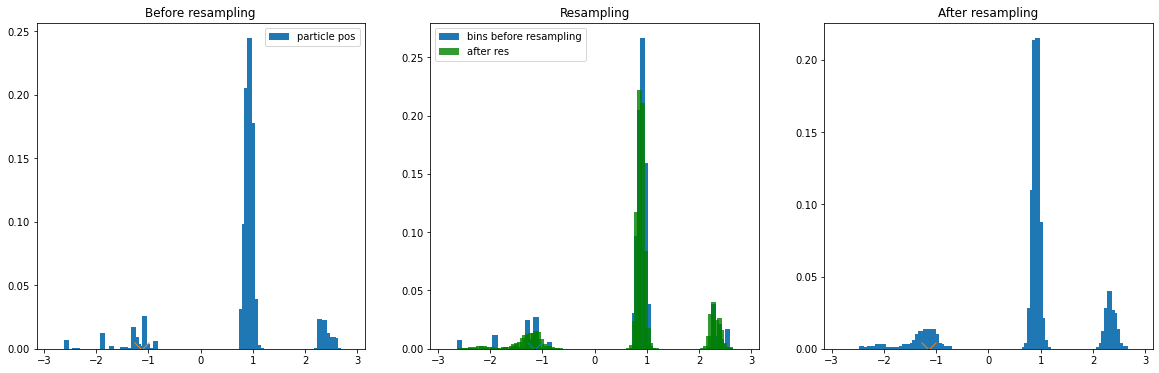

i= 9


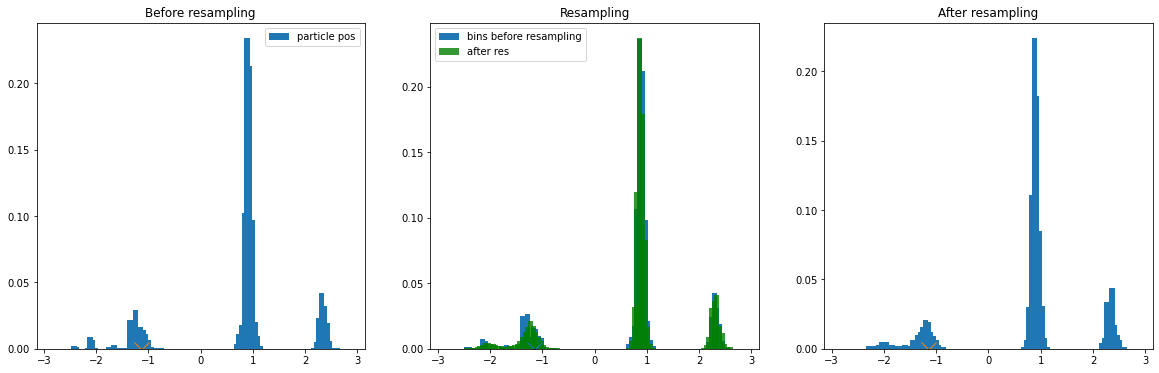

i= 10


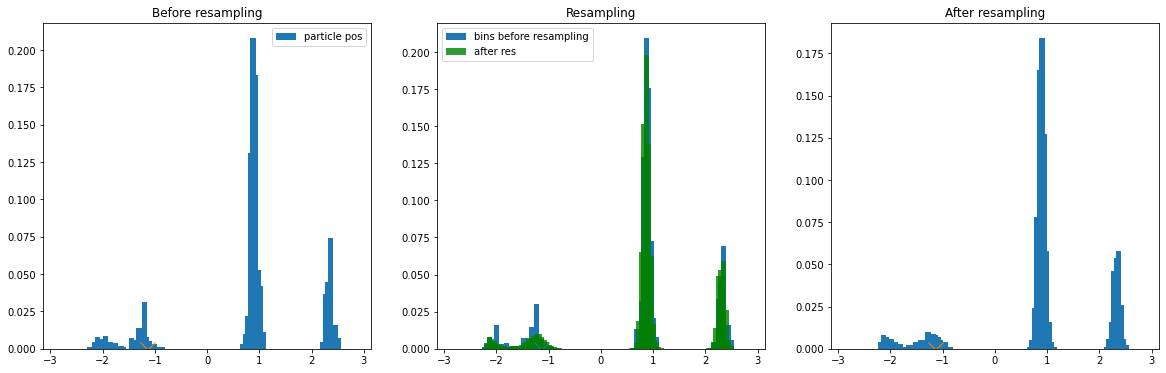

i= 11


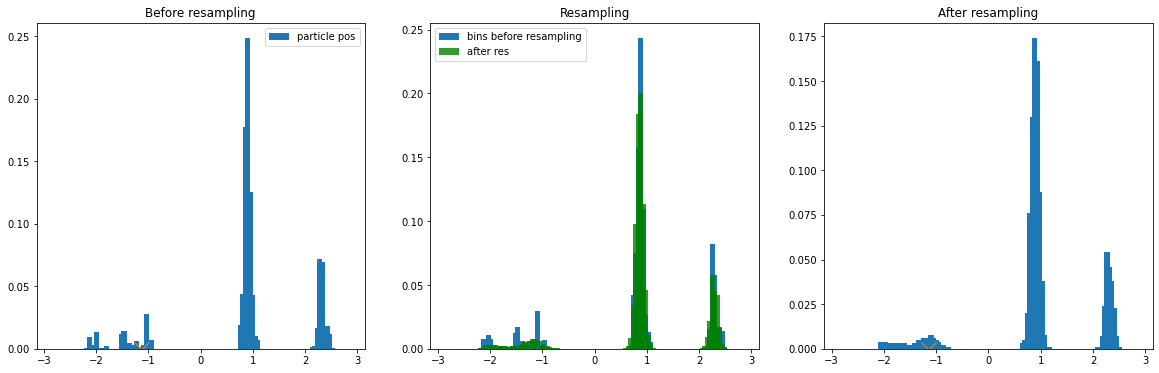

i= 12


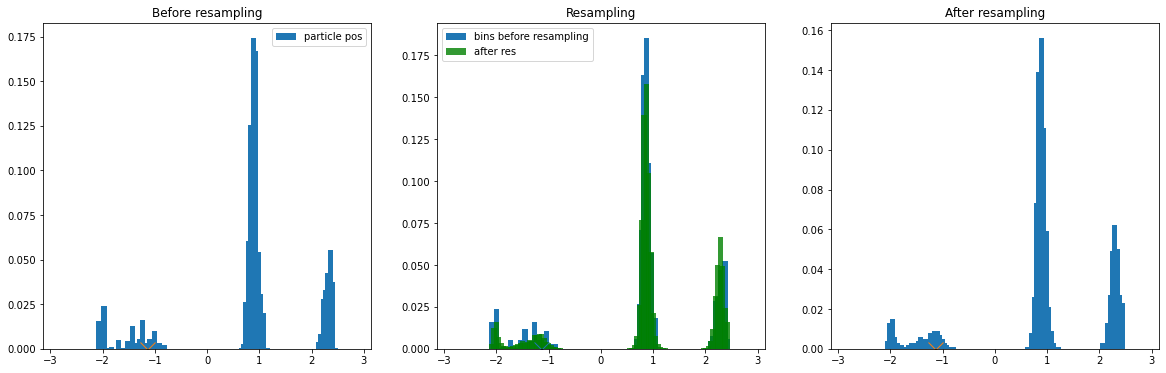

i= 13


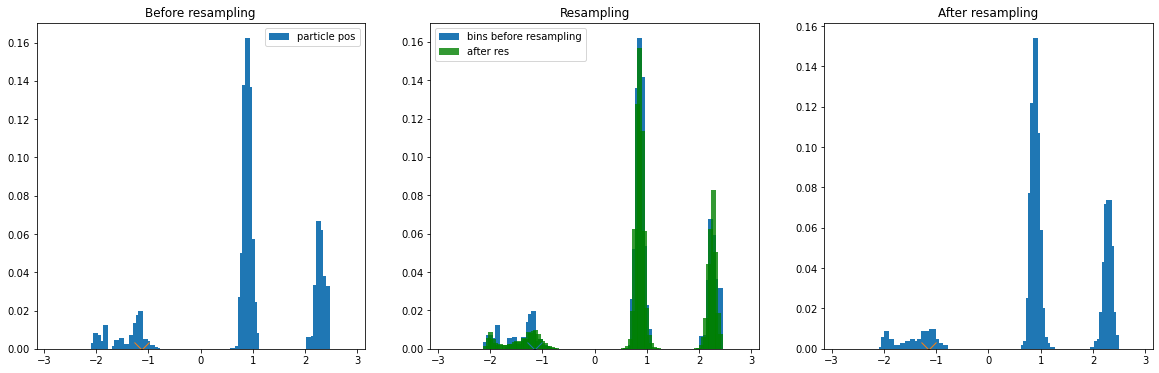

i= 14


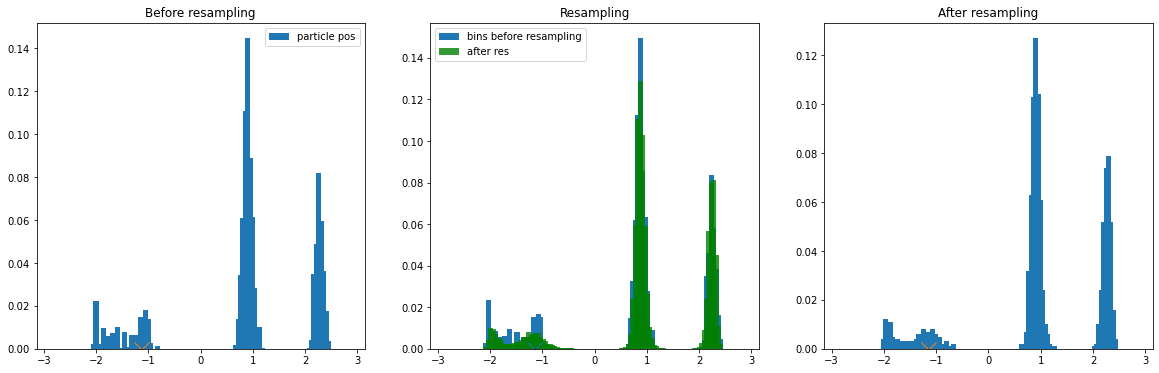

i= 15


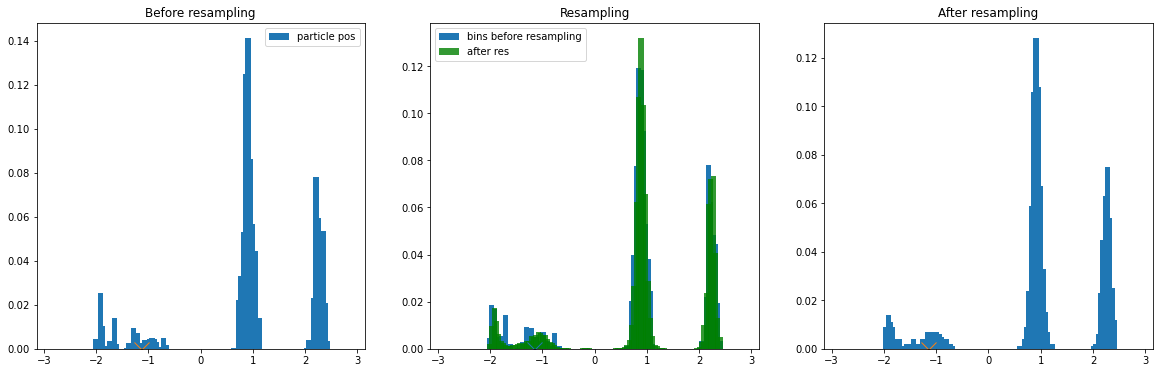

i= 16


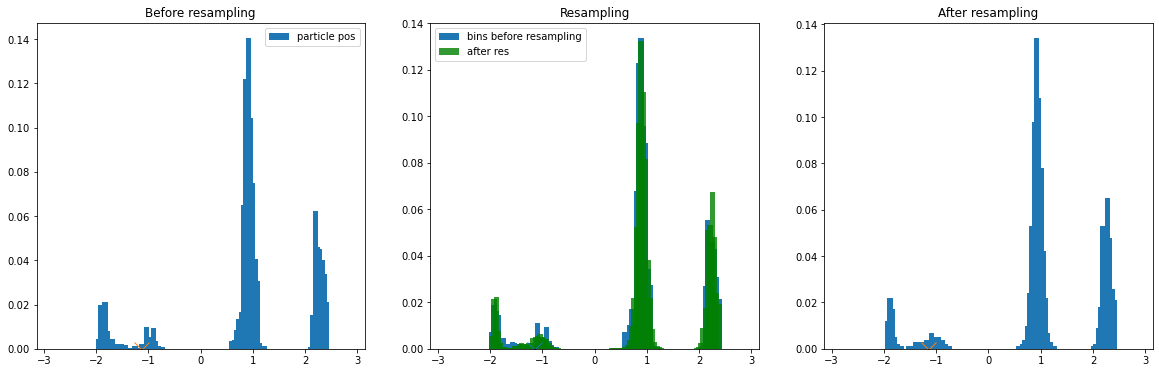

i= 17


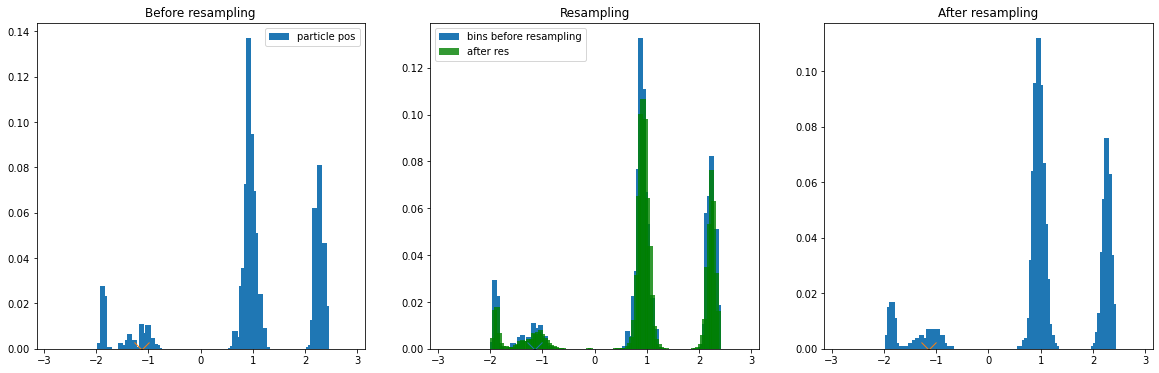

i= 18


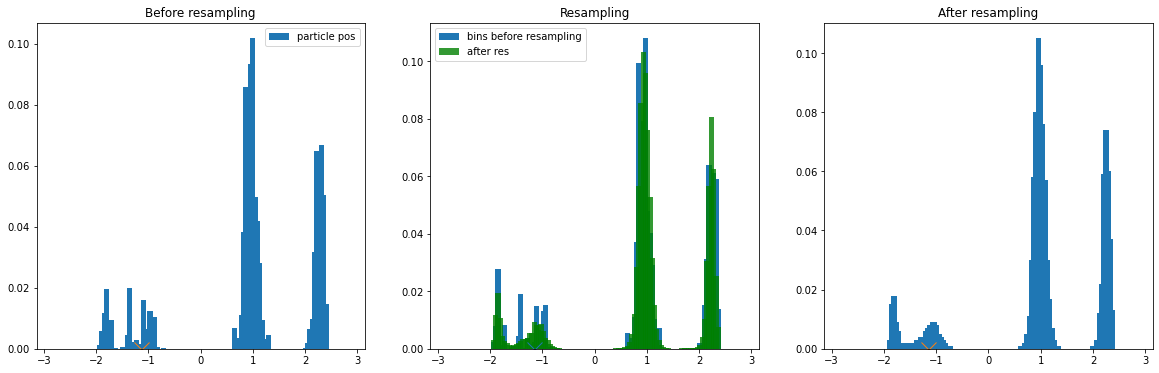

i= 19


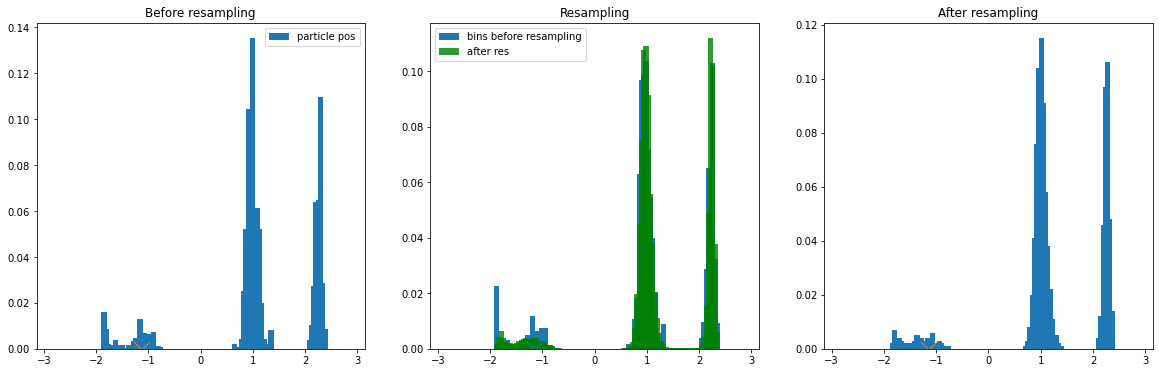

i= 20


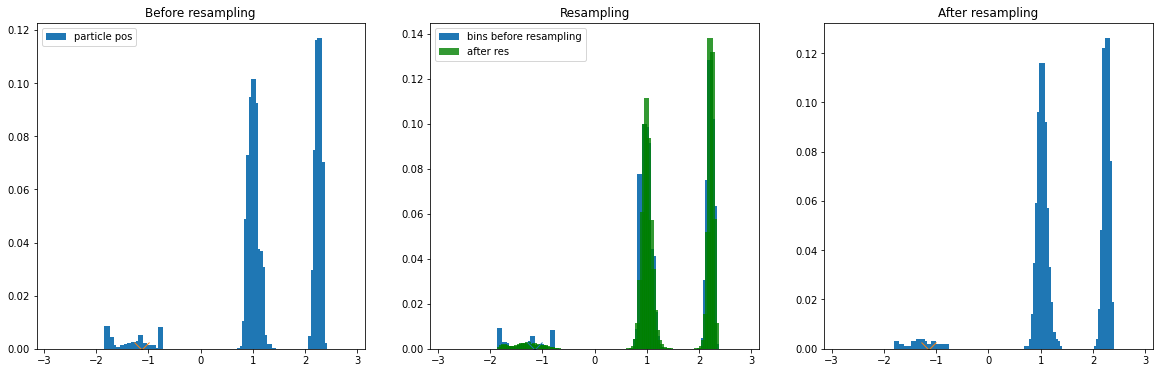

i= 21


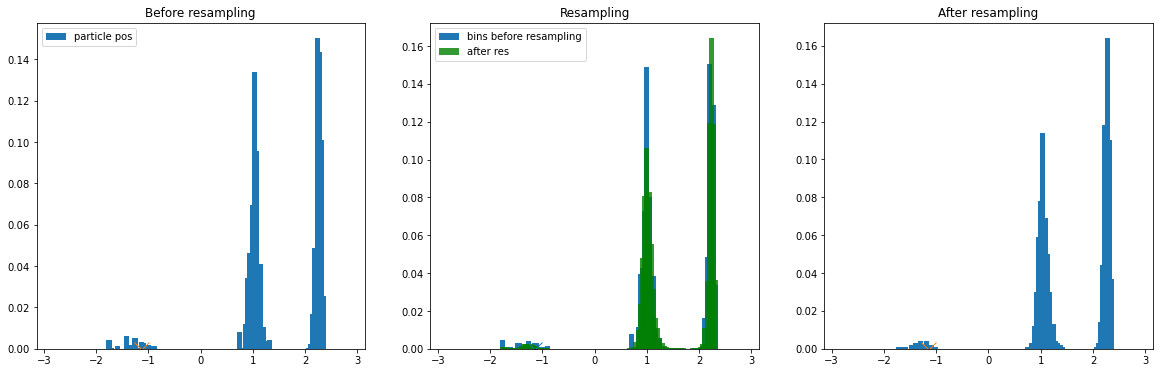

i= 22


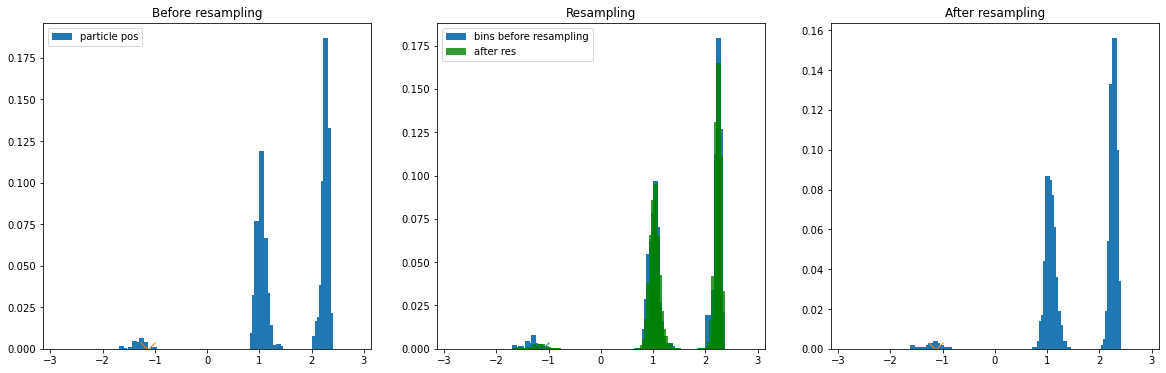

i= 23


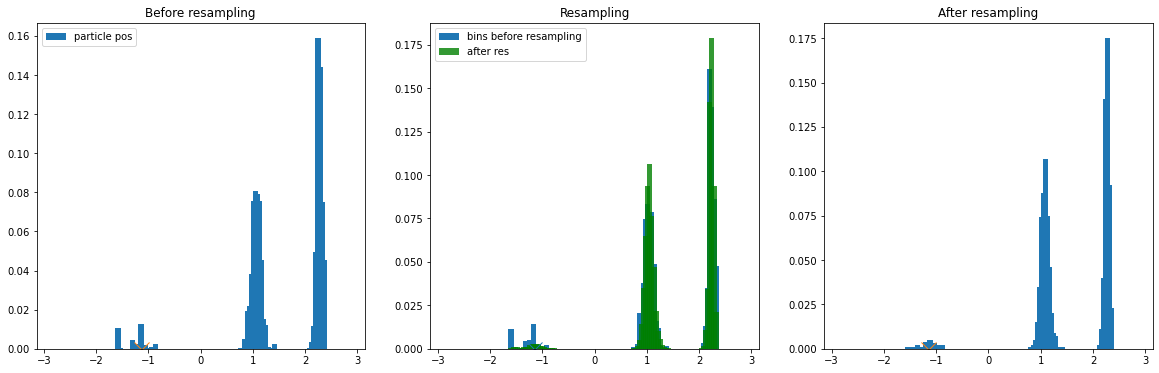

i= 24


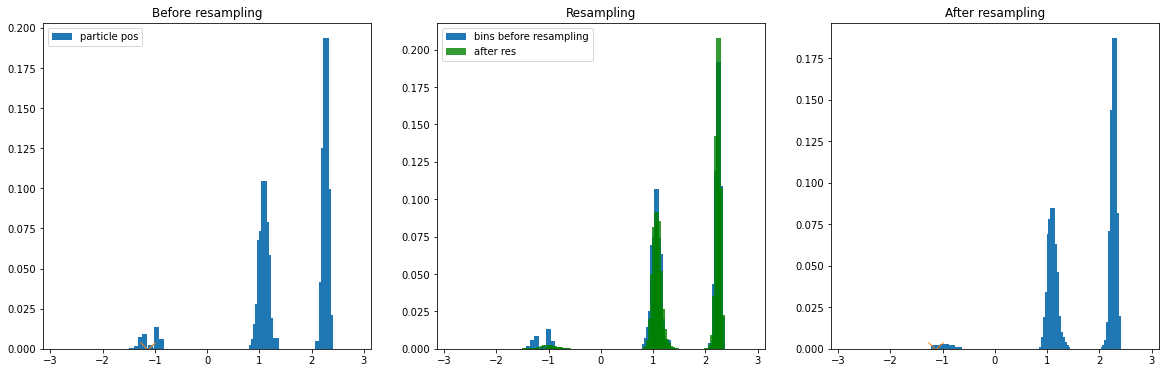

i= 25


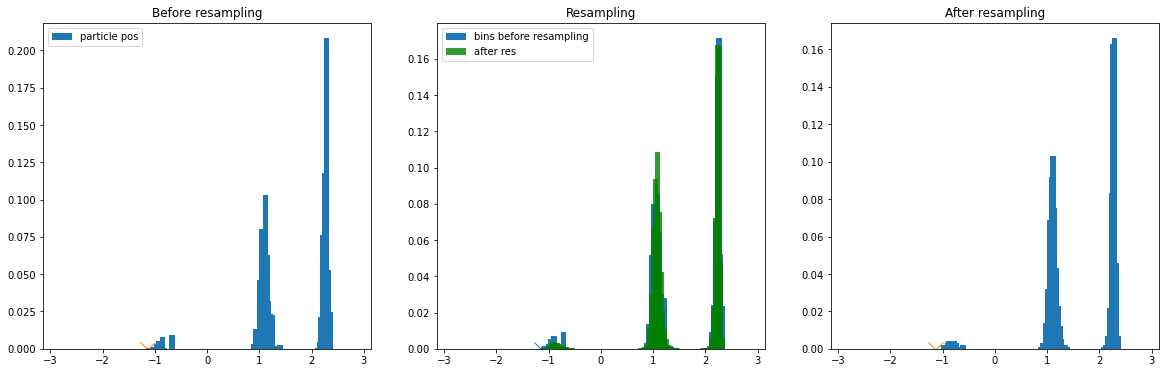

i= 26


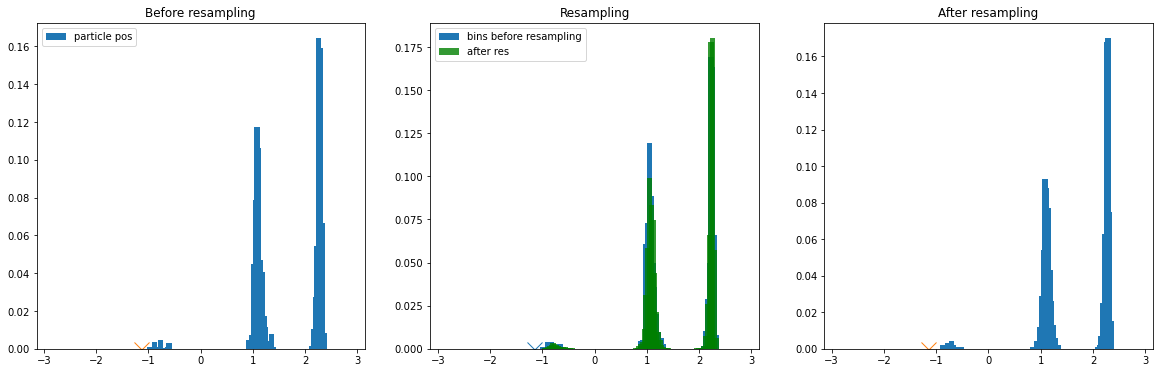

i= 27


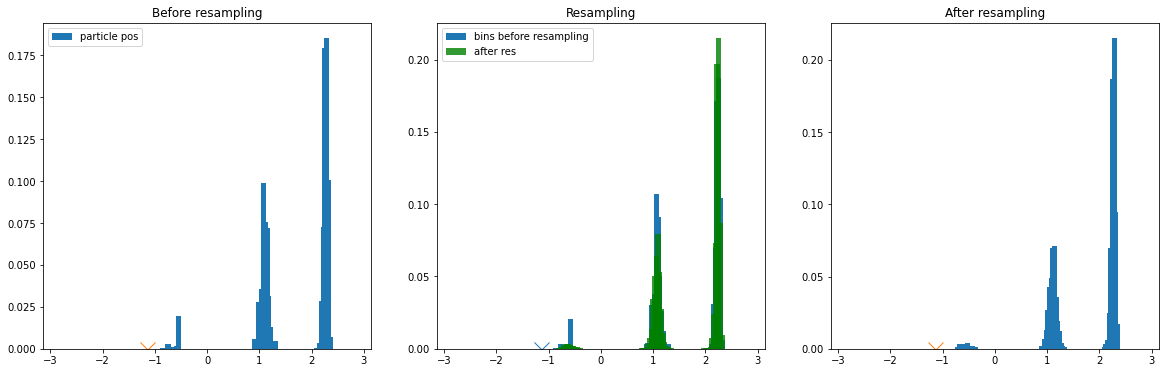

i= 28


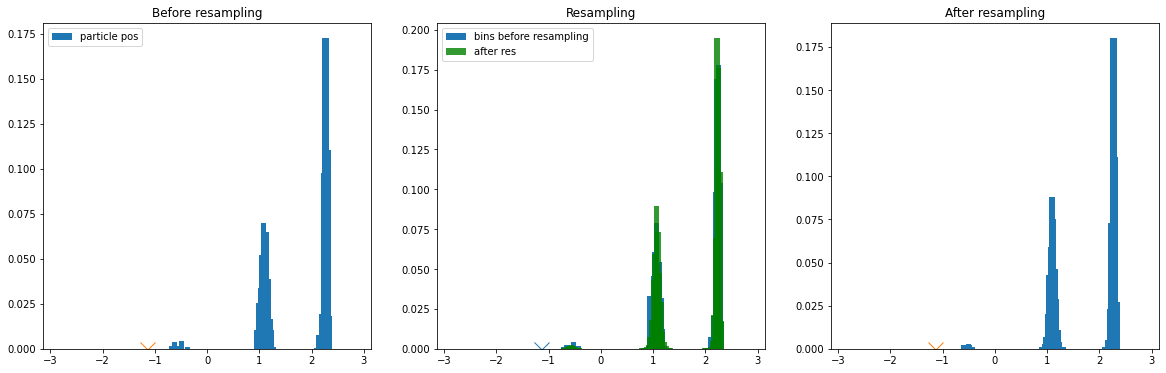

i= 29


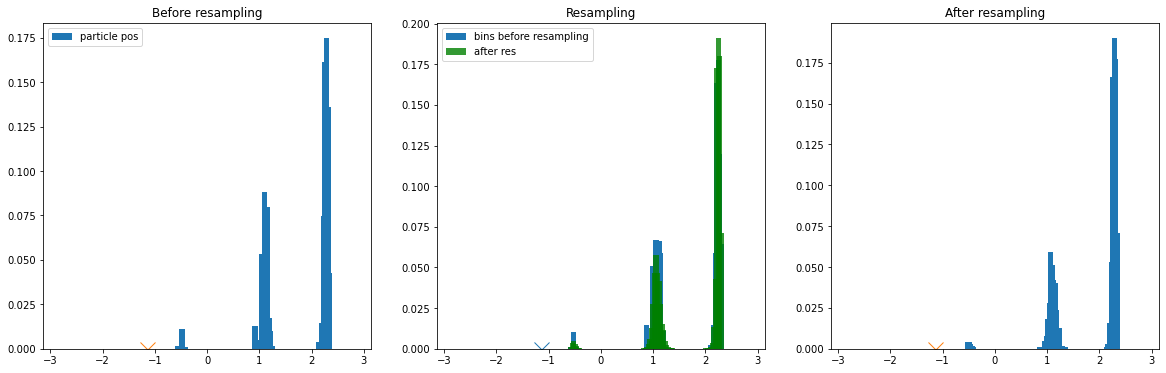

i= 30


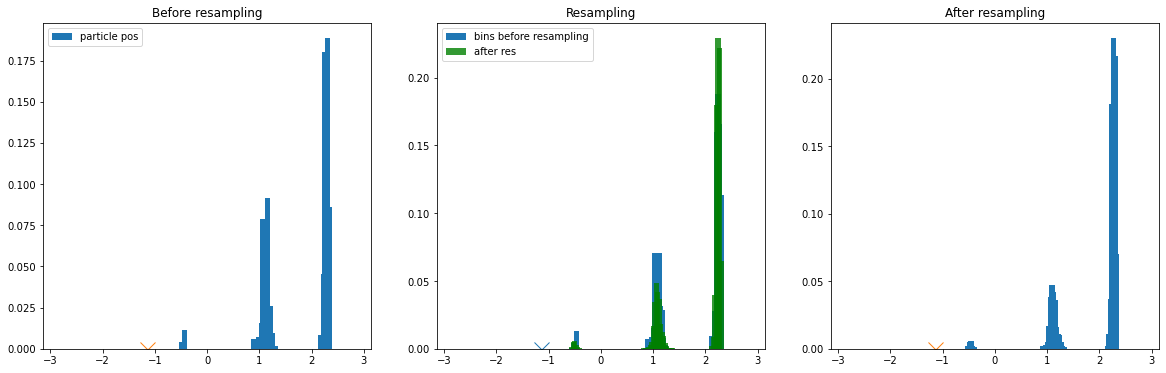

i= 31


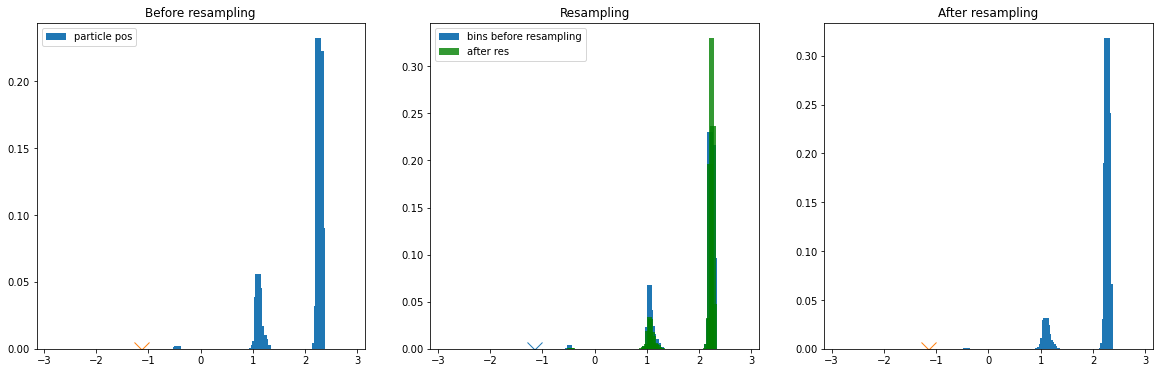

i= 32


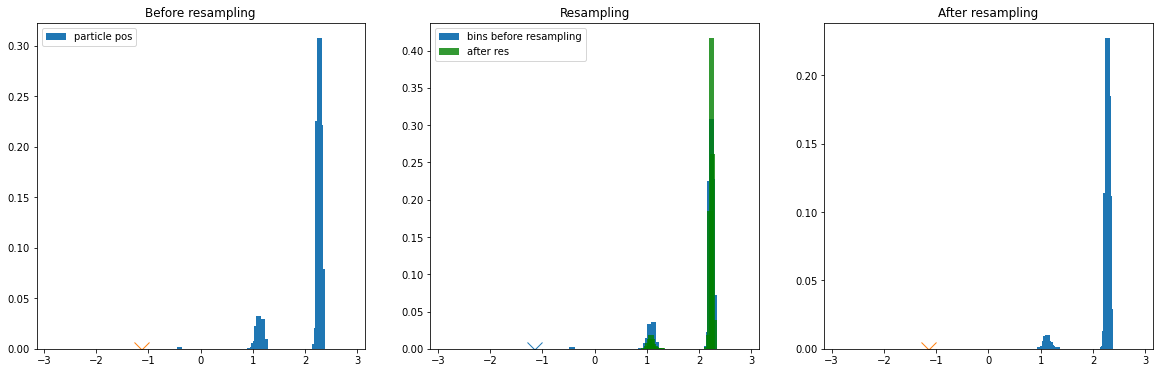

i= 33


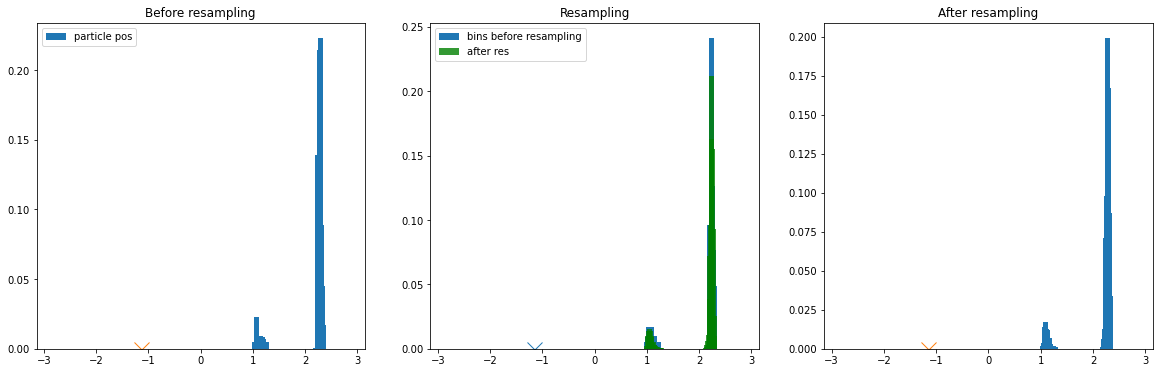

i= 34


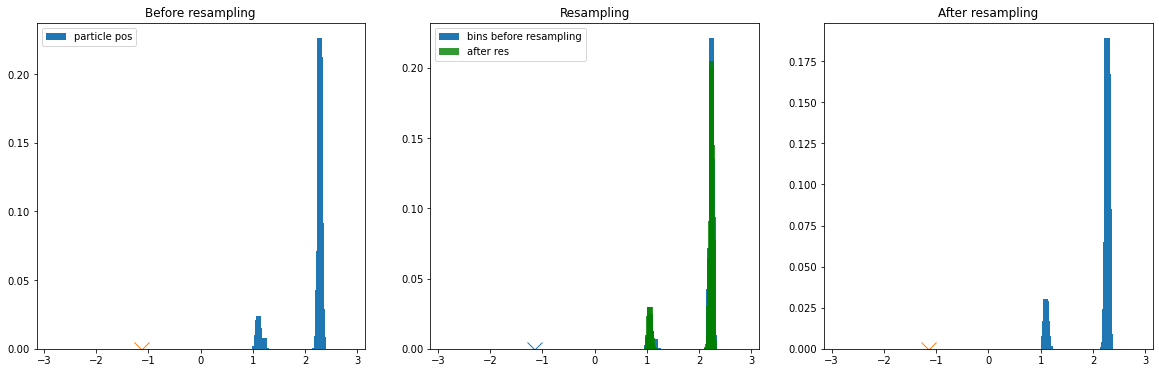

i= 35


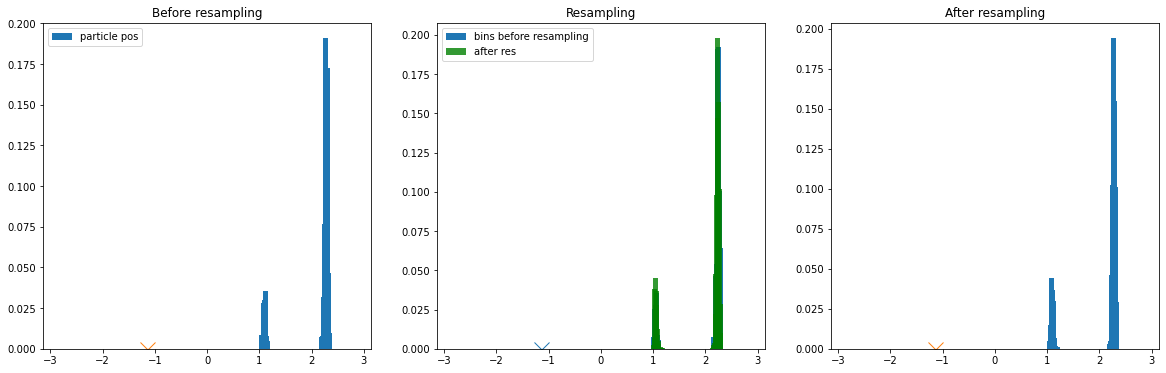

i= 36


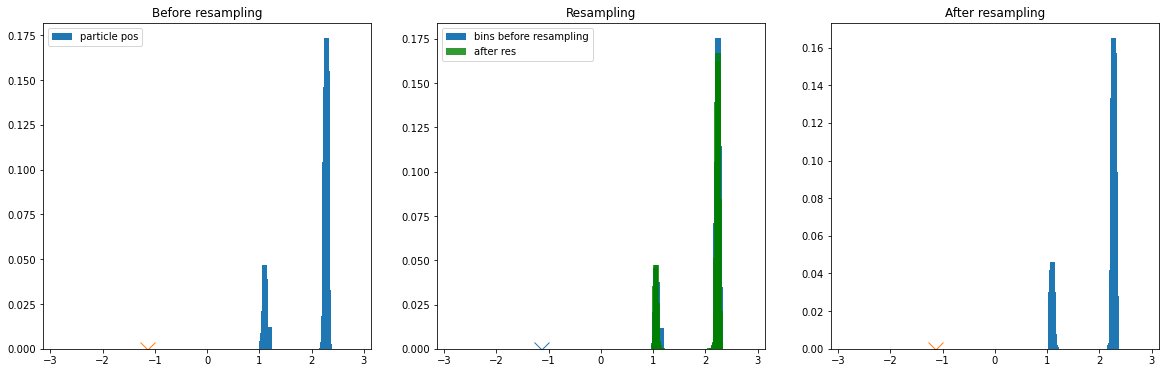

i= 37


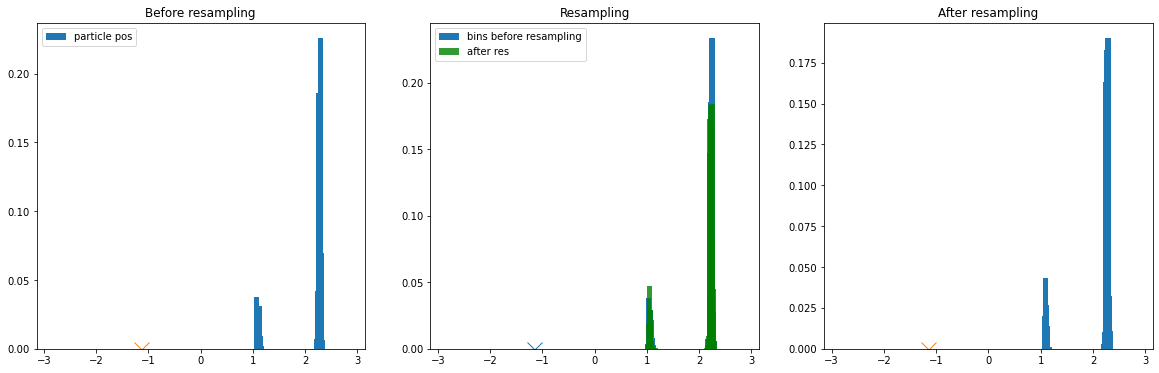

i= 38


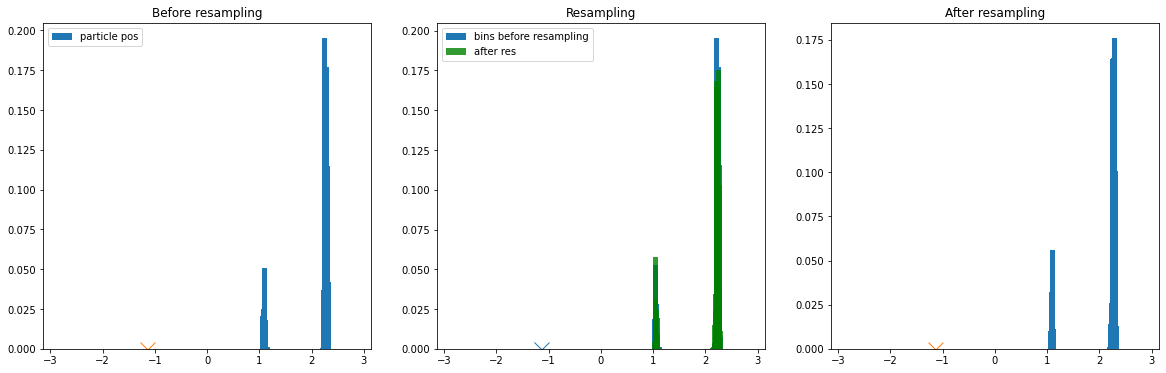

i= 39


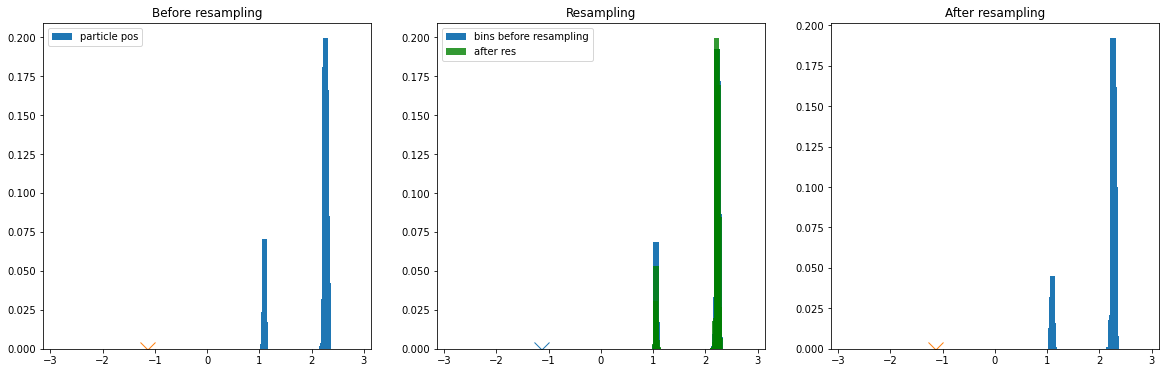

i= 40


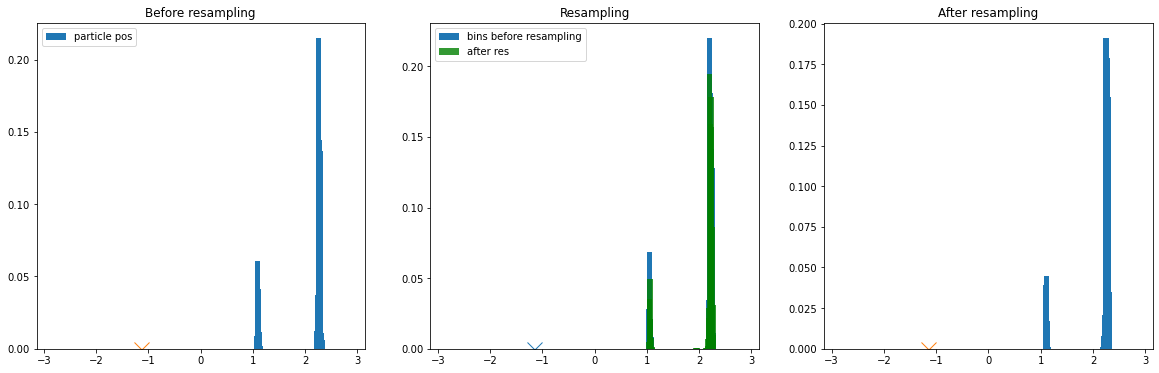

i= 41


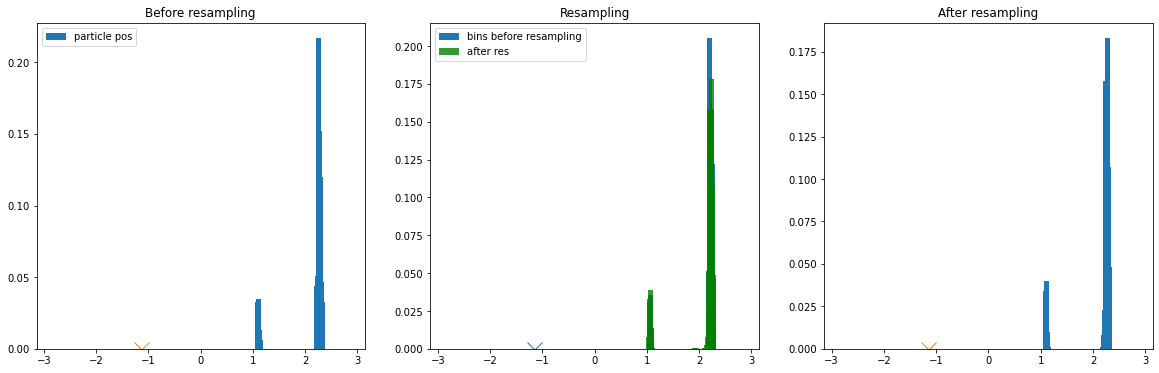

i= 42


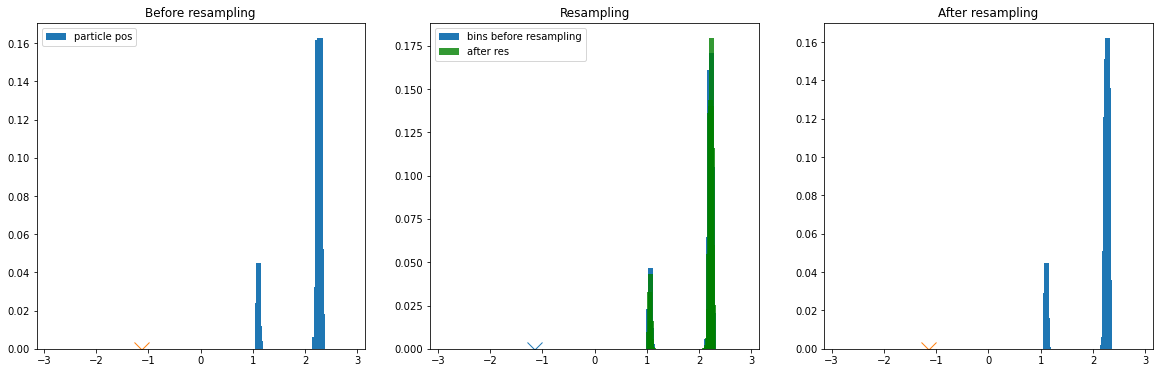

i= 43


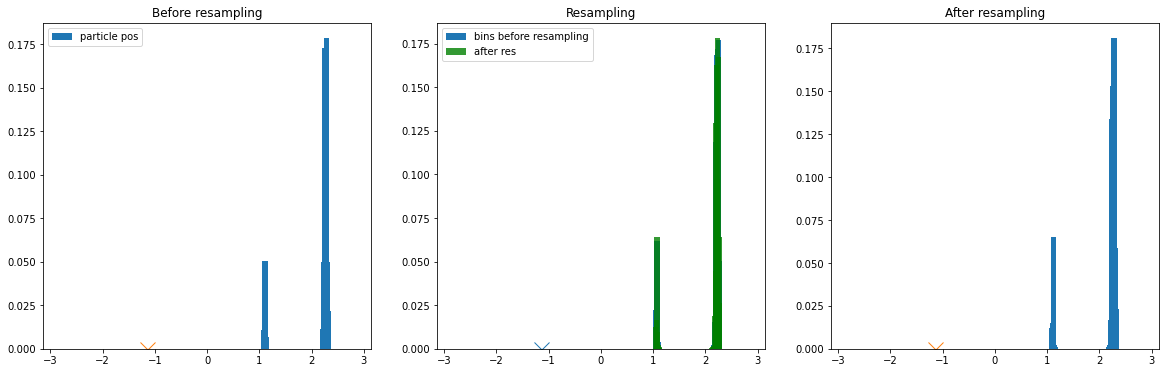

i= 44


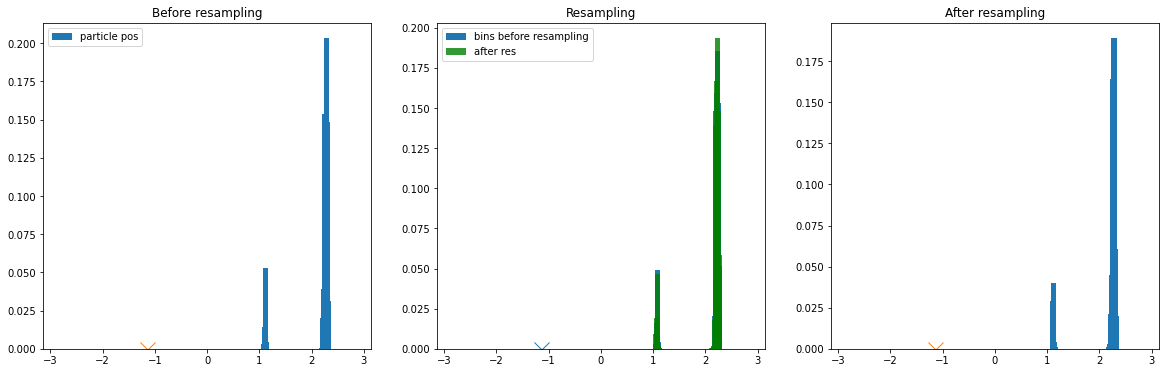

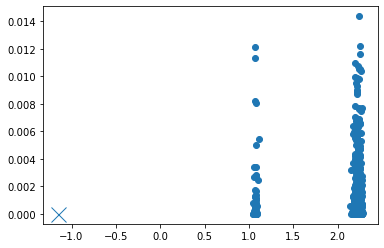

In [35]:
for i in range(len(smc.memory.pos_wgt_bef_res)-1):
    pos_bef_res = smc.memory.pos_wgt_bef_res[i][0]
    wgt_bef_res = smc.memory.pos_wgt_bef_res[i][1]
    bins_bef_res = smc.memory.bins_edges_bef_res[i][0]
    edges_bef_res = smc.memory.bins_edges_bef_res[i][1]
    bins_aft_res = smc.memory.bins_edges_aft_res[i][0]
    edges_aft_res = edges_bef_res
    pos_aft_res = smc.memory.pos_wgt_aft_res[i][0]
    wgt_aft_res = smc.memory.pos_wgt_aft_res[i][1]
    edge_width = edges_bef_res[1] - edges_bef_res[0]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))
                                                  
    print("i=", i)
    
    ax1.hist(pos_bef_res, bins = num_bins, weights = wgt_bef_res, label='particle pos', width=0.1)
    #ax1.bar(edges_bef_res, bins_bef_res, align='edge', width = edge_width, alpha=0.5,color='green', label='bins before res')
    ax1.set_xlim([-np.pi, np.pi])
    ax1.plot(true_omega, 0,marker='x', markersize=15)
    ax1.set_title("Before resampling")
    ax1.legend()
    
    ax2.bar(edges_bef_res, bins_bef_res, align='center', width = 0.1, label='bins before resampling')
    ax2.bar(edges_aft_res, bins_aft_res, align='center', width = 0.1, label='after res' ,alpha=0.8, color='green')
    ax2.set_xlim([-np.pi, np.pi])
    ax2.plot(true_omega, 0,marker='x', markersize=15)
    ax2.set_title("Resampling")
    ax2.legend()
    
    ax3.hist(pos_aft_res, bins = num_bins, weights = wgt_aft_res, width=0.1)
    ax3.plot(true_omega, 0,marker='x', markersize=15)
    ax3.set_xlim([-np.pi, np.pi])
    ax3.set_title("After resampling")
    
    plt.show()

plt.scatter(smc.particle_pos, smc.particle_wgts)
ax = plt.gca()
ax.plot(true_omega, 0,marker='x', markersize=15)
plt.show()
    

## Liu-West resampler

In [36]:
true_omegas = []
lw_preds = []
lw_data = []

for i in range(n_iters): 
    true_omega = np.random.uniform(low=-1, high=1) * np.pi
    
    true_omegas.append(true_omega)
    smc = phase_est_smc(true_omega, t0, max_iters)
    smc.init_particles(num_particles)
    
    resample_counts = 0
    
    while True:

        particle_pos, particle_wgts = smc.particles(threshold=num_particles/5, num_measurements=1)
        smc.liu_west_resample()
    
        resample_counts += 1 
        
        if smc.break_flag == True:
            break
        
#         if len(running_est) > 5:
#             last_5 = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shape of last_10 with every element being last_10[0]
#             # if all elements of last_10 are equal then they should all equal the first element
#             if np.allclose(last_5, np.full_like(last_5, last_5[0])):
#                 break

    while len(smc.data) < max_iters:
        smc.data.append(smc.data[-1]) # append the last estimate

    lw_data.append(smc.data)
    lw_preds.append(smc.curr_omega_est)
    
    if np.abs(true_omega - smc.curr_omega_est) > 1:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}. Failed".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))
        break
    else:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))
    

True omega: -0.628421, prediction by NN: 2.519034, num of resample calls: 46. Failed


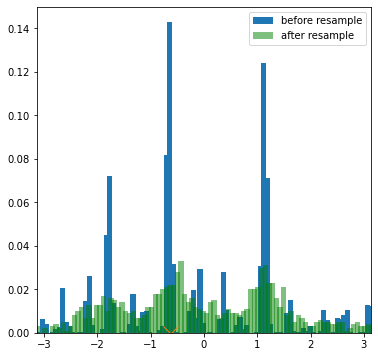

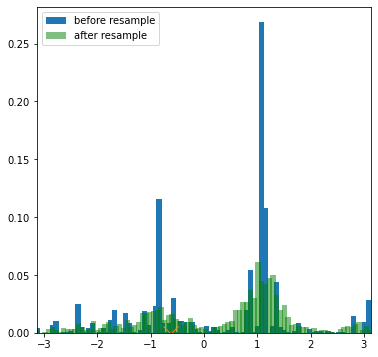

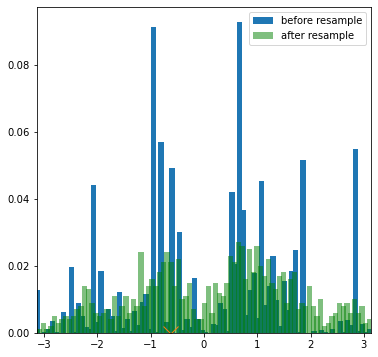

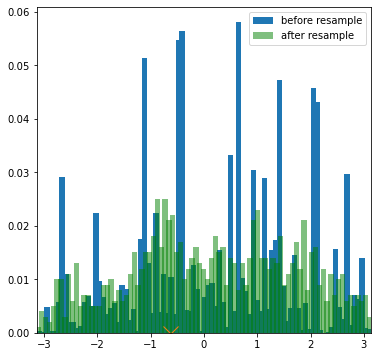

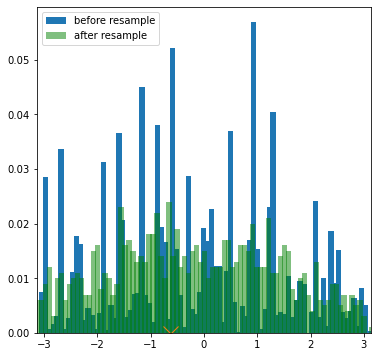

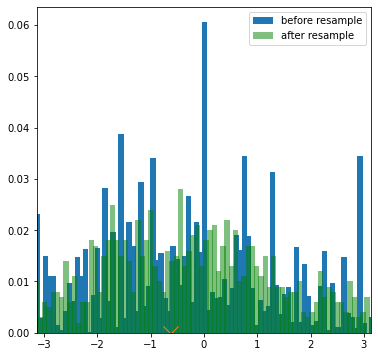

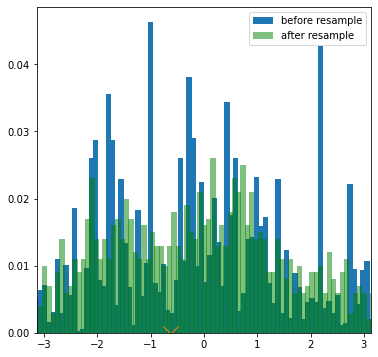

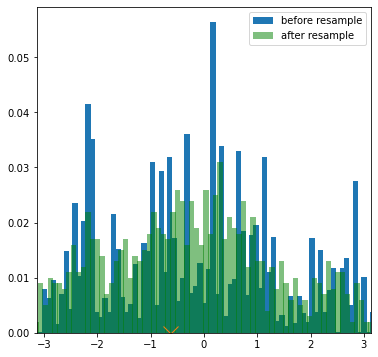

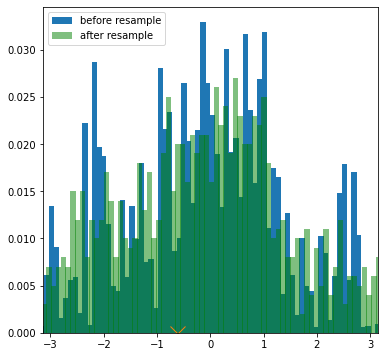

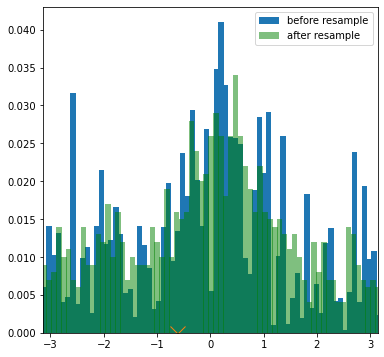

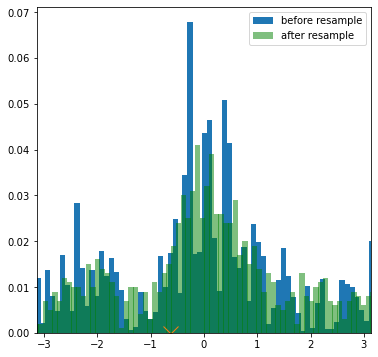

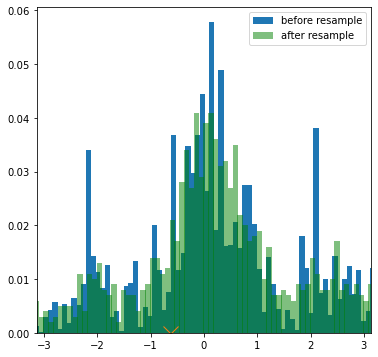

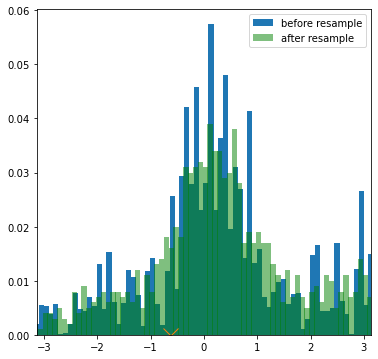

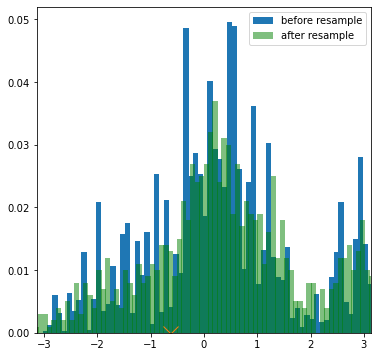

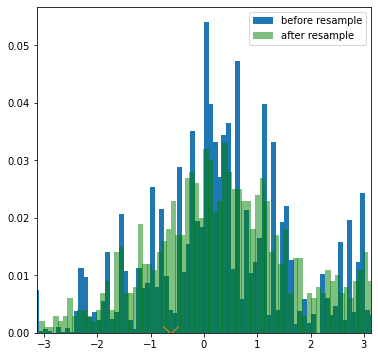

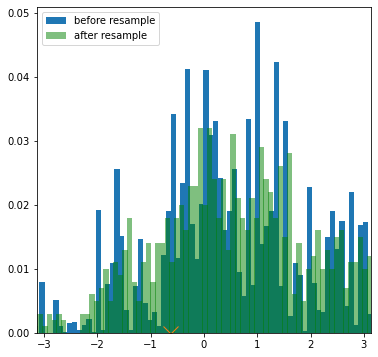

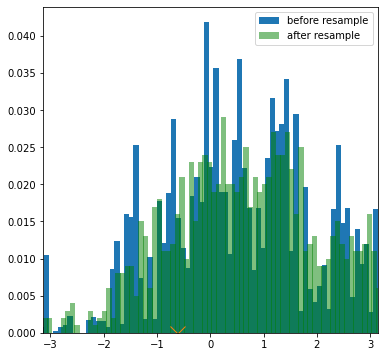

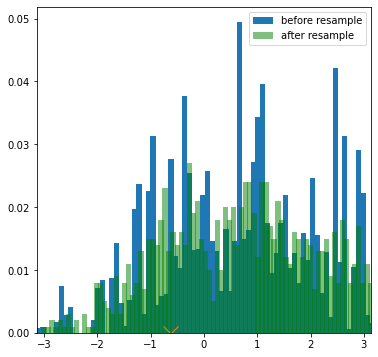

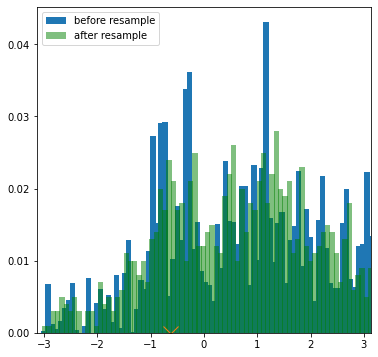

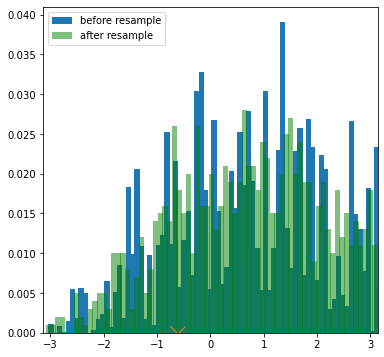

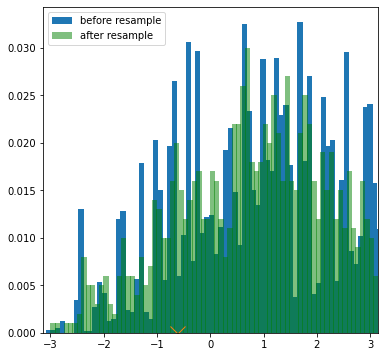

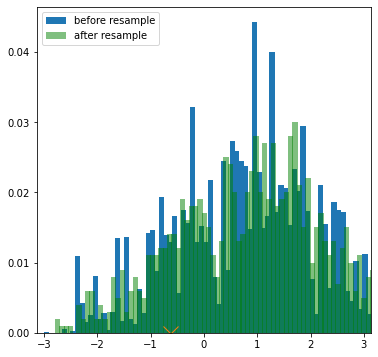

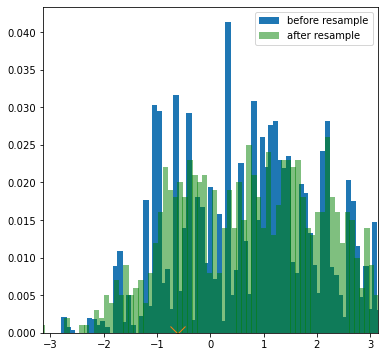

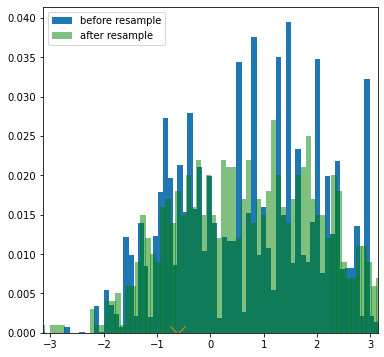

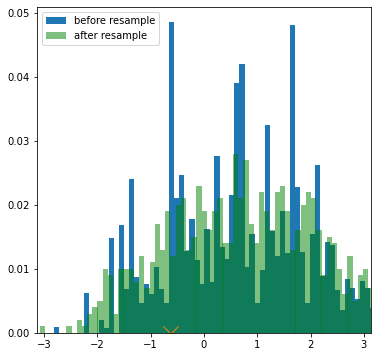

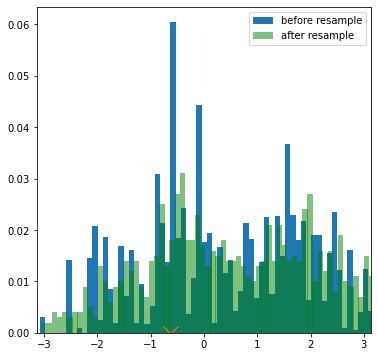

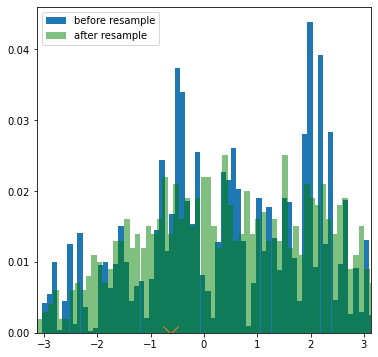

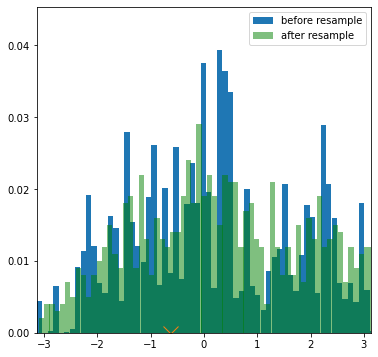

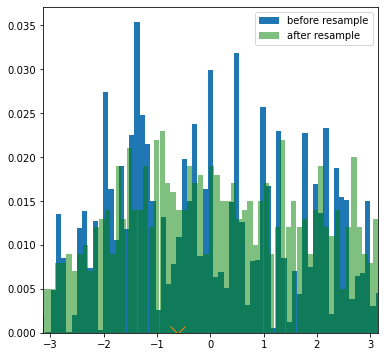

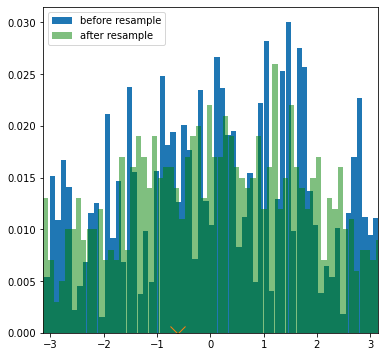

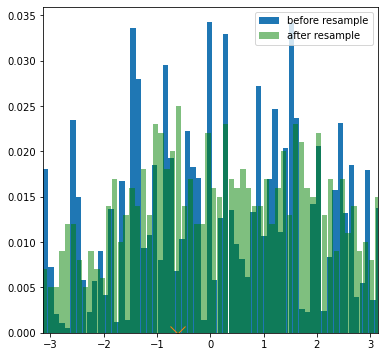

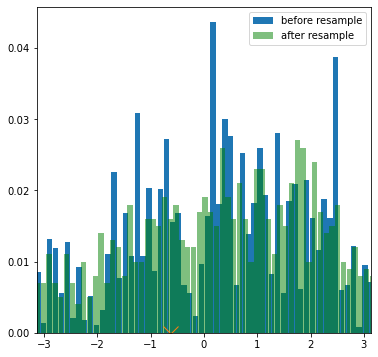

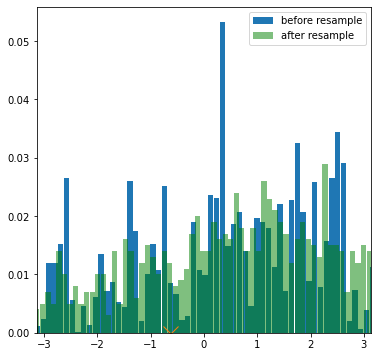

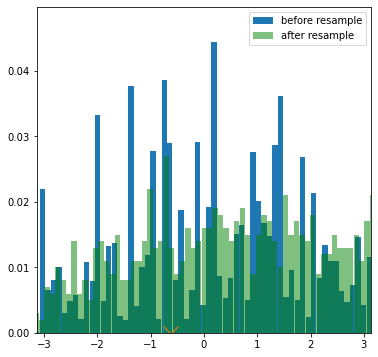

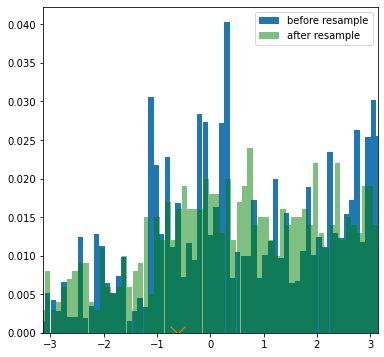

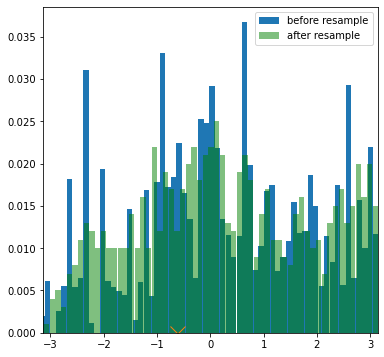

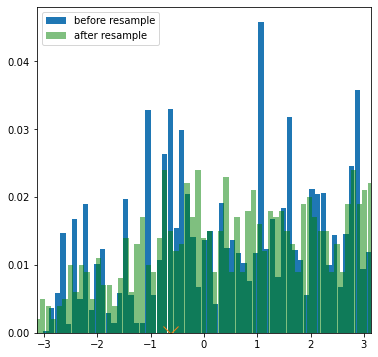

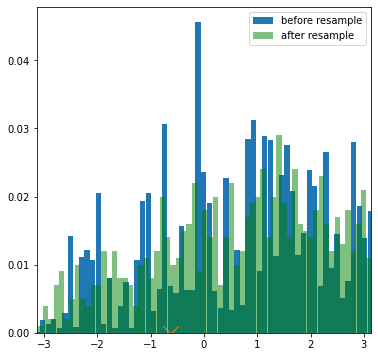

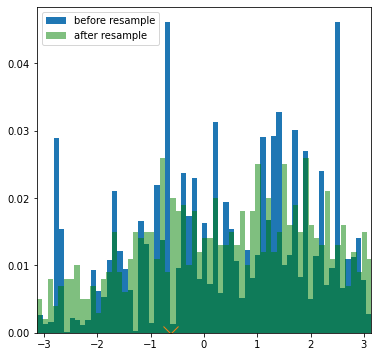

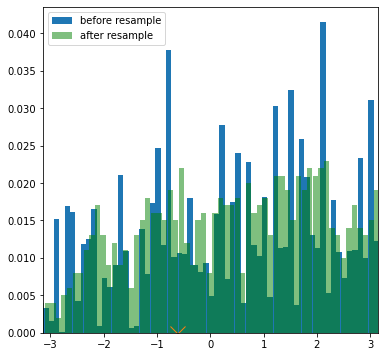

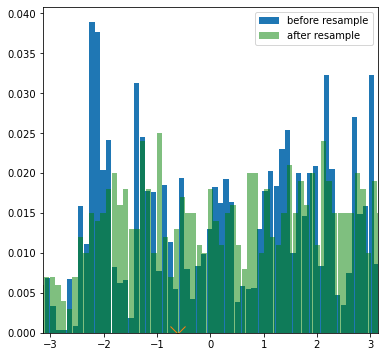

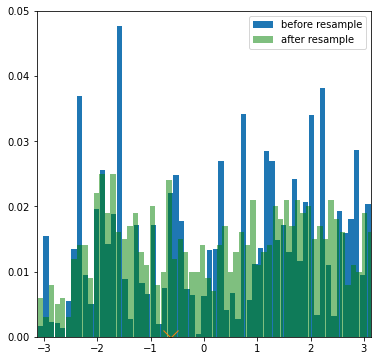

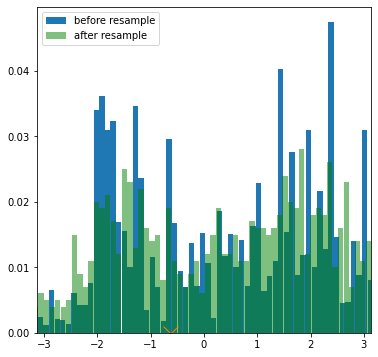

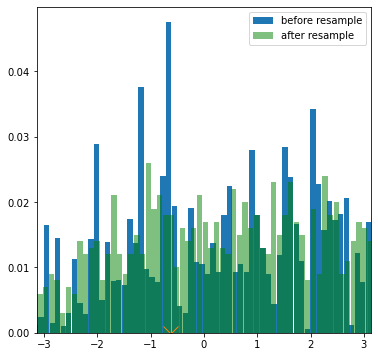

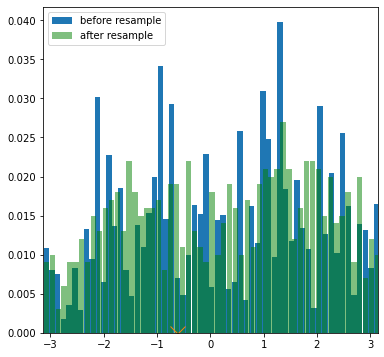

In [37]:
for i in range(len(smc.memory.pos_wgt_bef_res)-1):
    pos_bef_res = smc.memory.pos_wgt_bef_res[i][0]
    wgt_bef_res = smc.memory.pos_wgt_bef_res[i][1]
    pos_aft_res = smc.memory.pos_wgt_aft_res[i][0]
    wgt_aft_res = smc.memory.pos_wgt_aft_res[i][1]

    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    
    ax.hist(pos_bef_res, bins = num_bins, weights = wgt_bef_res, label='before resample', width = 0.1)
    ax.hist(pos_aft_res, bins = num_bins, weights = wgt_aft_res, alpha=0.5, color='green', label='after resample', width=0.1)
    ax.set_xlim([-np.pi, np.pi])
    ax.plot(true_omega, 0,marker='x', markersize=15)
    ax.legend()
    plt.show()
    
    